In [214]:
import func.task1 as t1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import skimage.io as skio
import skimage.transform as sktr
import skimage.color as skcol

import sklearn.model_selection as le_ms
import sklearn.preprocessing as le_pr
import sklearn.linear_model as le_lm
import sklearn.metrics as le_me

import tensorflow.keras.applications.inception_v3 as ki3
import tensorflow.keras.applications.resnet50 as k50

from importlib import reload
reload(t1)
from tqdm.notebook import tqdm

import yaml

%matplotlib inline

## About
Cardiomegaly: enlargement of the heart


In [215]:
with open("func/params.yaml", "r") as f:
    dict_params = yaml.full_load(f)["task1"]

dict_params

{'crop': {'n_rows': 8,
  'n_cols': 8,
  'range_rows': [1, 7],
  'range_cols': [4, 7]},
 'transfer_learning': {'ResNet50': {'new_img_dims': [224, 224],
   'to_rgb': True},
  'InceptionV3': {'new_img_dims': [299, 299], 'to_rgb': True}},
 'classification': [{'LogisticRegression': None,
   'penalty': 'l1',
   'C': 0.5,
   'solver': 'liblinear'}]}

In [216]:
df_info = pd.read_csv("dataset/dataInfo.csv", index_col=False)
df_info["filepath"] = df_info["FullFileName"].apply(lambda path: os.path.join("dataset", path))
df_info

,imgID,FileName,Cardiomegaly,Train,Findings,PatAge,PatGender,ViewPos,OrigWidth,OrigHeight,OrigPixSpacingX,OrigPixSpacingY,FullFileName,filepath
0,0,00000001_000.png,1,1,Cardiomegaly,058Y,M,PA,2682,2749,0.143,0.143,train/00000001_000.png,dataset/train/00000001_000.png
1,3,00000002_000.png,0,1,No Finding,081Y,M,PA,2500,2048,0.171,0.171,train/00000002_000.png,dataset/train/00000002_000.png
2,13,00000005_000.png,0,1,No Finding,069Y,F,PA,2048,2500,0.168,0.168,train/00000005_000.png,dataset/train/00000005_000.png
3,21,00000006_000.png,0,1,No Finding,081Y,M,PA,2500,2048,0.168,0.168,train/00000006_000.png,dataset/train/00000006_000.png
4,22,00000007_000.png,0,1,No Finding,082Y,M,PA,2500,2048,0.168,0.168,train/00000007_000.png,dataset/train/00000007_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21961,112114,00030801_000.png,0,1,No Finding,039Y,M,PA,2500,2048,0.168,0.168,train/00030801_000.png,dataset/train/00030801_000.png
21962,112116,00030802_000.png,0,1,No Finding,029Y,M,PA,2048,2500,0.168,0.168,train/00030802_000.png,dataset/train/00030802_000.png
21963,112117,00030803_000.png,0,1,No Finding,042Y,F,PA,2048,2500,0.168,0.168,train/00030803_000.png,dataset/train/00030803_000.png
21964,112118,00030804_000.png,0,1,No Finding,030Y,F,PA,2048,2500,0.168,0.168,train/00030804_000.png,dataset/train/00030804_000.png


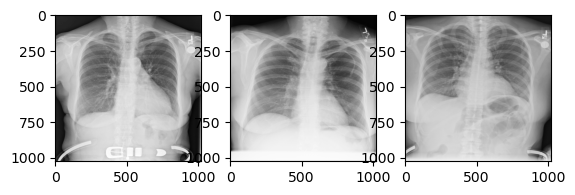

In [217]:
filepath_test_case = df_info[df_info["Cardiomegaly"] == 1].iloc[1]["filepath"]
filepath_test_control = df_info[df_info["Cardiomegaly"] == 0].iloc[1]["filepath"]
filepath_example = "dataset/train/00000083_000.png"
fig, axes = plt.subplots(1, 3)
axes[0].imshow(skio.imread(filepath_test_case), cmap="gray")
axes[1].imshow(skio.imread(filepath_test_control), cmap="gray")
axes[2].imshow(skio.imread(filepath_example), cmap="gray");

In [218]:
code_obj = t1.Task1()

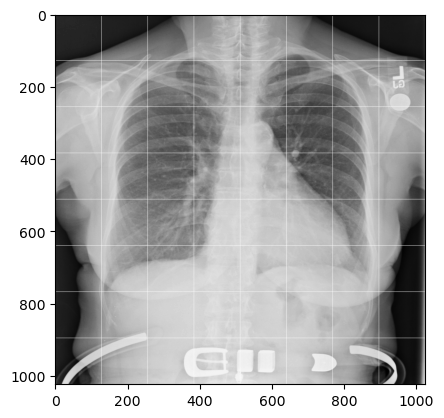

In [219]:
img_regions = code_obj.draw_regions(filepath_test_case, n_rows=8, n_cols=8)
# img_regions = code_obj.draw_regions(filepath_test_case, n_rows=2, n_cols=2)
plt.imshow(img_regions, cmap="gray")

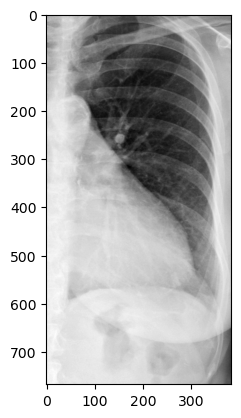

In [220]:
img_cropped = code_obj.crop_img_by_region(filepath_test_case, n_rows=8, n_cols=8, range_rows=(1, 7), range_cols=(4, 7))
plt.imshow(img_cropped, cmap="gray")

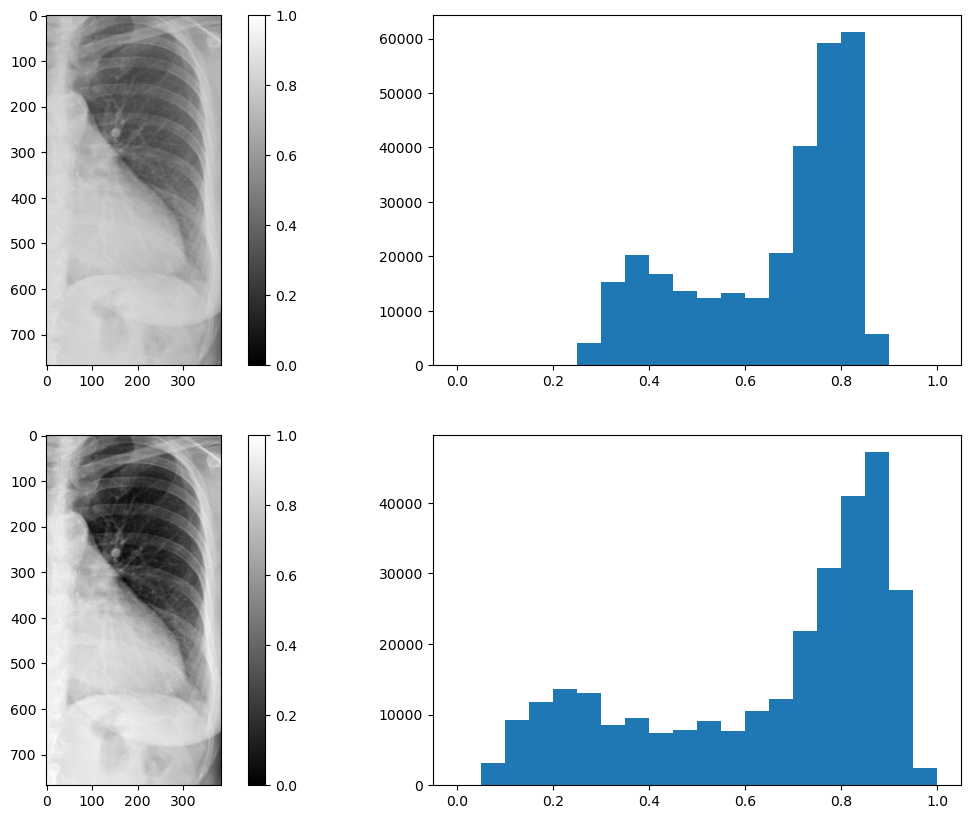

In [221]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
img_cropped_stretched = code_obj.contrast_stretch(img_cropped, lowest_pixel=None)
list_img = [img_cropped, img_cropped_stretched]

for i in [0, 1]:
    disp = axes[i, 0].imshow(list_img[i], cmap="gray", vmin=0, vmax=1)
    axes[i, 1].hist(list_img[i].flatten(), bins=20, range=(0, 1))
    plt.colorbar(disp, ax=axes[i, 0])


## Pipeline 1
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to Inception V3 format
4. Save image
5. Create feature matrix
6. Run Logistic Regression
7. Run evaluation
8. Draw ROC curve

((299, 299), (768, 384))

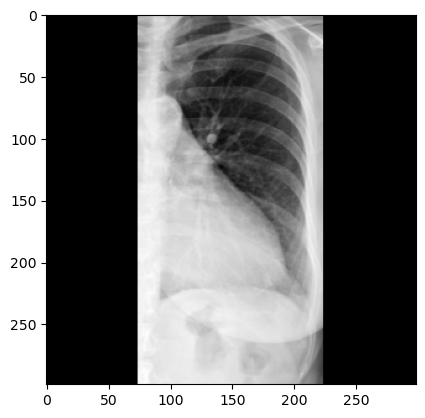

In [222]:
img_rescaled = code_obj.transform_img_to_size(img_cropped_stretched, (299, 299), to_rgb=False)
plt.imshow(img_rescaled, cmap="gray")
img_rescaled.shape, img_cropped_stretched.shape

## Pipeline 2
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to ResNet50 format
4. Save image
5. Create feature matrix
6. Run Logistic Regression
7. Run evaluation
8. Draw ROC curve

((224, 224, 3), (768, 384))

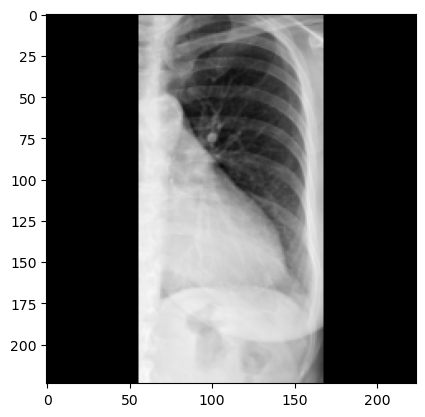

In [223]:
img_rescaled_r50 = code_obj.transform_img_to_size(img_cropped_stretched, (224, 224), to_rgb=True)
plt.imshow(img_rescaled_r50)
img_rescaled_r50.shape, img_cropped_stretched.shape

## Pipeline 3
1. Crop region of interest
2. Perform contrast stretching
3. Convert image to VGG16 format
4. Save image
5. Create feature matrix
6. Run Logistic Regression
7. Run evaluation
8. Draw ROC curve

## Loading results

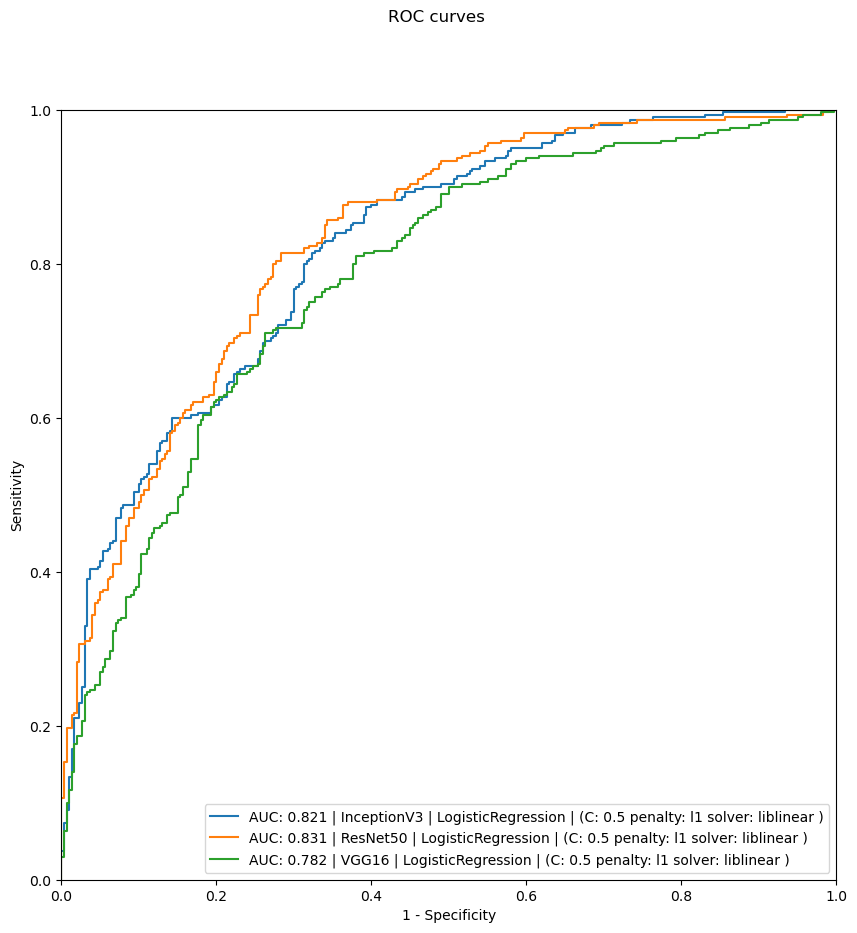

In [227]:
fig = code_obj.load_plot_roc()
fig.savefig("all_roc.png")